In [2]:

import warnings, math, gc, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, confusion_matrix
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight

from lightgbm import LGBMClassifier
import joblib

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)


In [3]:
# === Configure your data source here ===
DATA_URL = "https://drive.usercontent.google.com/download?id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV&export=download&authuser=0&confirm=t"  # Added confirm=t to bypass virus scan warning
LOCAL_CSV_PATH = None  # e.g., r"C:/path/to/your/file.csv"  # set to a real path if you downloaded the CSV

# Memory-friendly dtypes for PaySim-style data
DTYPES = {
    "step": "int16",
    "type": "category",
    "amount": "float32",
    "nameOrig": "category",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "nameDest": "category",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "uint8",
    "isFlaggedFraud": "uint8",
}

print("Reading dataset... (this may take a few minutes for 6.3M rows)")
if LOCAL_CSV_PATH and os.path.exists(LOCAL_CSV_PATH):
    df = pd.read_csv(LOCAL_CSV_PATH, dtype=DTYPES)
else:
    df = pd.read_csv(DATA_URL, dtype=DTYPES)

print(df.shape)
df.head()

Reading dataset... (this may take a few minutes for 6.3M rows)
(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0


In [4]:

# Missing values
print("Nulls per column:")
print(df.isnull().sum())

# Duplicates
dups = df.duplicated().sum()
print("\nDuplicate rows:", dups)

# Class balance
print("\nClass balance (isFraud):")
print(df['isFraud'].value_counts(dropna=False))
print("Fraud rate: %.6f" % (df['isFraud'].mean()))

# Quick stats for amount (skewed)
print("\nAmount describe:")
print(df['amount'].describe(percentiles=[0.5, 0.9, 0.99, 0.999]))


Nulls per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Duplicate rows: 0

Class balance (isFraud):
isFraud
0    6354407
1       8213
Name: count, dtype: int64
Fraud rate: 0.001291

Amount describe:
count    6.362620e+06
mean     1.798619e+05
std      5.991358e+05
min      0.000000e+00
50%      7.487194e+04
90%      3.654233e+05
99%      1.615980e+06
99.9%    8.956798e+06
max      9.244552e+07
Name: amount, dtype: float64


In [5]:

# Add a log amount for better behavior under skew
df['log_amount'] = np.log1p(df['amount'].clip(lower=0))

# Basic visualization (optional): Uncomment if you want to plot locally
# plt.figure()
# df['log_amount'].hist(bins=100)
# plt.title("Distribution of log(amount)")
# plt.show()


In [6]:

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Type flags
    df['isTRANSFER'] = (df['type'] == 'TRANSFER').astype('uint8')
    df['isCASH_OUT'] = (df['type'] == 'CASH_OUT').astype('uint8')
    df['isPAYMENT'] = (df['type'] == 'PAYMENT').astype('uint8')
    df['isCASH_IN'] = (df['type'] == 'CASH-IN').astype('uint8')
    df['isDEBIT'] = (df['type'] == 'DEBIT').astype('uint8')

    # Merchant destination flag
    df['dest_is_merchant'] = df['nameDest'].astype(str).str.startswith('M').astype('uint8')

    # Ratios
    df['ratio_amount_oldOrg'] = df['amount'] / (df['oldbalanceOrg'].abs() + 1.0)
    df['ratio_amount_oldDest'] = df['amount'] / (df['oldbalanceDest'].abs() + 1.0)

    # Balance deltas (consistency checks)
    df['deltaOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
    df['deltaDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

    tol = 1e-3
    df['orig_mismatch'] = (df['deltaOrig'].abs() > tol).astype('uint8')
    df['dest_mismatch'] = (df['deltaDest'].abs() > tol).astype('uint8')

    # Oddity: zero to zero with amount > 0 (often seen in fraud)
    df['orig_zero_to_zero_with_amount'] = (
        (df['oldbalanceOrg'] == 0.0) & (df['newbalanceOrig'] == 0.0) & (df['amount'] > 0.0)
    ).astype('uint8')

    # Time features
    df['hour'] = (df['step'] % 24).astype('int8')
    df['day'] = (df['step'] // 24).astype('int16')

    return df

df = engineer_features(df)
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,log_amount,isTRANSFER,isCASH_OUT,isPAYMENT,isCASH_IN,isDEBIT,dest_is_merchant,ratio_amount_oldOrg,ratio_amount_oldDest,deltaOrig,deltaDest,orig_mismatch,dest_mismatch,orig_zero_to_zero_with_amount,hour,day
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0,9.194276,0,0,1,0,0,1,0.057834,9839.639648,0.0,9839.639648,0,1,0,1,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0,7.531167,0,0,1,0,0,1,0.087731,1864.280029,0.0,1864.280029,0,1,0,1,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0,5.204007,1,0,0,0,0,0,0.994505,181.000000,0.0,181.000000,0,1,0,1,0
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0,5.204007,0,1,0,0,0,0,0.994505,0.008545,0.0,21363.000000,0,1,0,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0,9.364703,0,0,1,0,0,1,0.280788,11668.139648,0.0,11668.139648,0,1,0,1,0


In [7]:

train_mask = df['step'] <= 600
valid_mask = ~train_mask

train = df.loc[train_mask].reset_index(drop=True)
valid = df.loc[valid_mask].reset_index(drop=True)

target_col = 'isFraud'

exclude = {'isFraud', 'nameOrig', 'nameDest'}  # drop high-cardinality IDs
num_cols = [
    "amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest",
    "ratio_amount_oldOrg","ratio_amount_oldDest",
    "deltaOrig","deltaDest",
    "log_amount",
    "orig_mismatch","dest_mismatch","orig_zero_to_zero_with_amount",
    "isTRANSFER","isCASH_OUT","isPAYMENT","isCASH_IN","isDEBIT",
    "dest_is_merchant","hour","day",
    "isFlaggedFraud",
]
cat_cols = ["type"]

features = [c for c in num_cols if c not in exclude] + cat_cols

X_train = train[features]
y_train = train[target_col].astype('uint8')
X_valid = valid[features]
y_valid = valid[target_col].astype('uint8')

print(X_train.shape, X_valid.shape)


(6259047, 23) (103573, 23)


In [8]:

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols),
        ('num', 'passthrough', [c for c in features if c not in cat_cols]),
    ],
    remainder='drop',
    sparse_threshold=0.3,
)

clf = LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=40,
    reg_alpha=0.1,
    reg_lambda=0.2,
    random_state=42,
    n_jobs=-1,
)

pipe = Pipeline(steps=[('prep', preprocess), ('lgbm', clf)])

# Imbalance: weight classes
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

print("Training model...")
pipe.fit(X_train, y_train, lgbm__sample_weight=sample_weight)
print("Done.")


Training model...
[LightGBM] [Info] Number of positive: 6613, number of negative: 6252434
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.278791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 6259047, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

ROC-AUC  : 1.00000
PR-AUC   : 1.00000


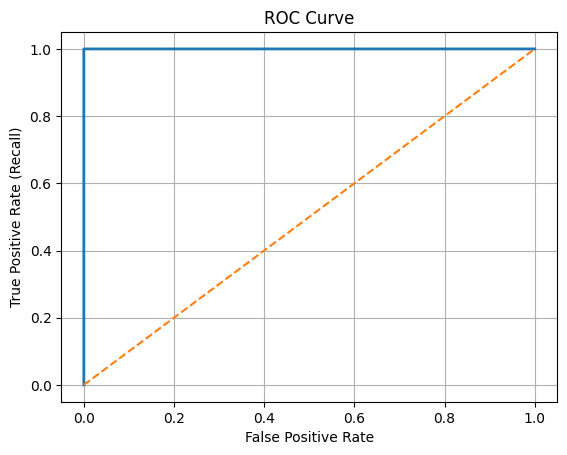

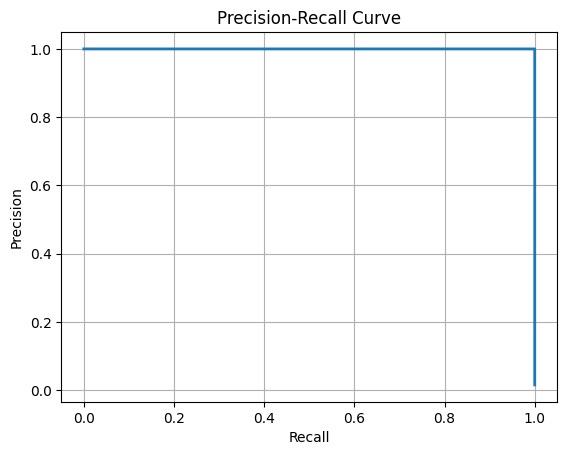

Max Recall at FPR<=0.5%: 1.0000


In [9]:

valid_proba = pipe.predict_proba(X_valid)[:, 1]

roc = roc_auc_score(y_valid, valid_proba)
pr_auc = average_precision_score(y_valid, valid_proba)
print(f"ROC-AUC  : {roc:.5f}")
print(f"PR-AUC   : {pr_auc:.5f}")

# ROC curve
fpr, tpr, thr_roc = roc_curve(y_valid, valid_proba)

plt.figure()
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.grid(True)
plt.show()

# PR curve
prec, rec, thr_pr = precision_recall_curve(y_valid, valid_proba)
plt.figure()
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

# Recall at FPR <= 0.005 (0.5%)
import numpy as np
mask = fpr <= 0.005
recall_low_fpr = tpr[mask].max() if mask.any() else np.nan
print(f"Max Recall at FPR<=0.5%: {recall_low_fpr:.4f}")


In [10]:

C_FALSE_NEG = 1000.0  # cost of missing a fraud
C_FALSE_POS = 5.0     # cost of reviewing a legit txn

def eval_at_threshold(y_true, p, thr):
    pred = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    tpr = tp / (tp + fn + 1e-9)
    fpr = fp / (fp + tn + 1e-9)
    prec = tp / (tp + fp + 1e-9)
    return dict(threshold=thr, tp=tp, fp=fp, tn=tn, fn=fn, precision=prec, recall=tpr, fpr=fpr)

best = None
for t in np.linspace(0.01, 0.99, 99):
    m = eval_at_threshold(y_valid.values, valid_proba, t)
    expected_cost = m['fn']*C_FALSE_NEG + m['fp']*C_FALSE_POS
    if best is None or expected_cost < best['expected_cost']:
        best = {**m, 'expected_cost': expected_cost}

print("Best threshold by expected cost:")
for k,v in best.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.6f}")
    else:
        print(f"  {k}: {v}")

BEST_THRESHOLD = best['threshold']


Best threshold by expected cost:
  threshold: 0.010000
  tp: 1600
  fp: 0
  tn: 101973
  fn: 0
  precision: 1.000000
  recall: 1.000000
  fpr: 0.000000
  expected_cost: 0.000000


In [11]:

pred = (valid_proba >= BEST_THRESHOLD).astype(int)
cm = confusion_matrix(y_valid, pred)
cm_df = pd.DataFrame(cm, index=['Actual 0','Actual 1'], columns=['Pred 0','Pred 1'])
cm_df


,Pred 0,Pred 1
Actual 0,101973,0
Actual 1,0,1600


In [12]:

# Fraud rate by transaction type in validation
val_copy = valid.copy()
val_copy['pred'] = pred
by_type = val_copy.groupby('type').agg(
    n=('isFraud','size'),
    fraud_rate=('isFraud','mean'),
    precision=('pred', lambda x: np.nan),  # placeholder
).reset_index()

# Compute precision by type for predicted positives
precisions = []
for t in val_copy['type'].cat.categories:
    subset = val_copy[val_copy['type'] == t]
    if subset.empty:
        precisions.append(np.nan)
    else:
        tp = ((subset['pred']==1) & (subset['isFraud']==1)).sum()
        pp = (subset['pred']==1).sum()
        precisions.append(tp / (pp + 1e-9))
by_type['precision'] = precisions

by_type.sort_values('fraud_rate', ascending=False)


,type,n,fraud_rate,precision
4,TRANSFER,10125,0.079012,1.0
1,CASH_OUT,33425,0.023934,1.0
0,CASH_IN,24059,0.000000,0.0
2,DEBIT,823,0.000000,0.0
3,PAYMENT,35141,0.000000,0.0


In [13]:

# Feature importance (gain)
lgbm = pipe.named_steps['lgbm']
importances = lgbm.booster_.feature_importance(importance_type='gain')
# Get feature names from ColumnTransformer
ohe = pipe.named_steps['prep'].named_transformers_['cat']
ohe_features = list(ohe.get_feature_names_out(['type']))
final_feature_names = ohe_features + [c for c in features if c not in ['type']]

imp_df = pd.DataFrame({
    'feature': final_feature_names,
    'gain_importance': importances
}).sort_values('gain_importance', ascending=False)
imp_df.head(20)


,feature,gain_importance
15,orig_mismatch,5.103212e+07
7,newbalanceOrig,2.067591e+07
12,deltaOrig,7.878497e+06
10,ratio_amount_oldOrg,4.266592e+06
3,type_PAYMENT,1.350609e+06
13,deltaDest,9.451536e+05
5,amount,9.375126e+05
11,ratio_amount_oldDest,5.979032e+05
6,oldbalanceOrg,3.748421e+05
14,log_amount,3.078997e+05


In [14]:

# Optional: SHAP on a validation sample
# !pip install shap  # if not installed
import shap, scipy.sparse as sp

# Prepare a manageable sample
N_SHAP = 5000
idx = np.random.RandomState(42).choice(len(X_valid), size=min(N_SHAP, len(X_valid)), replace=False)
Xv = X_valid.iloc[idx]

Xt = pipe.named_steps['prep'].transform(Xv)
if not sp.issparse(Xt):
    Xt = sp.csr_matrix(Xt)

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(Xt)

# Global summary plot (shows top drivers)
# shap.summary_plot(shap_values, Xt, feature_names=final_feature_names, show=False)
# plt.show()
print("Computed SHAP values on a sample of", Xt.shape[0], "rows.")


Computed SHAP values on a sample of 5000 rows.


In [15]:

MODEL_PATH = "fraud_lgbm.pkl"
THRESHOLD_PATH = "fraud_threshold.txt"

joblib.dump(pipe, MODEL_PATH)
with open(THRESHOLD_PATH, "w") as f:
    f.write(str(BEST_THRESHOLD))

print("Saved model to", MODEL_PATH)
print("Saved threshold to", THRESHOLD_PATH)


Saved model to fraud_lgbm.pkl
Saved threshold to fraud_threshold.txt
